EM is an iterative process that begins with some initialization and then alternates between the expectation and maximization steps until the algorithm reaches convergence.


1. Initialization:
Initialize the means μk, covariances μk,and mixing coefficients πk, and evaluate the initial value of the log likelihood.

It is common to run K-means first to find a suitable initialization for the EM algorithm. The covariance matricies  Σk can be initialized to the sample covariances of the clusters found by K-means. The mixing coefficients πk can be set to the fractions of data points assigned to the respective cluster, i.e.

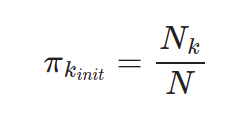

2. The E step:
We calculate the expected values E(zij), which is the probability that xi was drawn from the jth distribution.

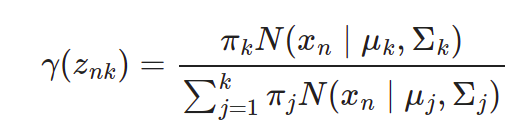
 
The formula simply states that the expected value for zij is the probability xi given μj divided by the sum of the probabilities that xi belonged to each μ.

3. The M step:
Re-estimate the parameters using the current responsibilities

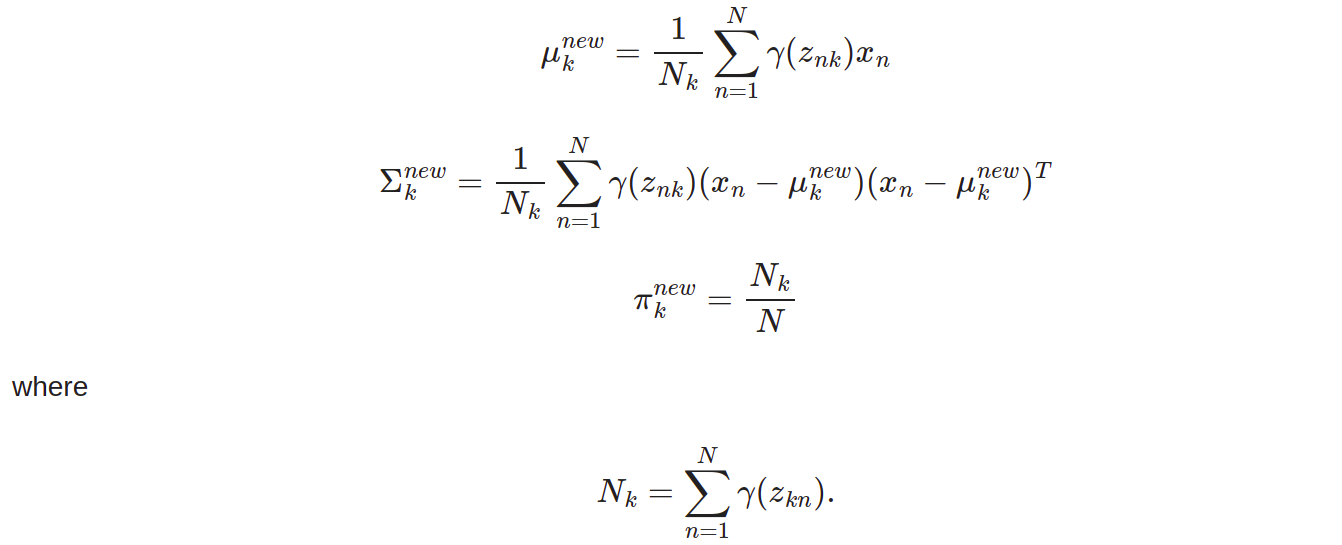

By repeating the E-step and M-step we are guaranteed to increase the log likelihood, so it will converge to a local Maximum. 

4. Evaluate the log likelihood:

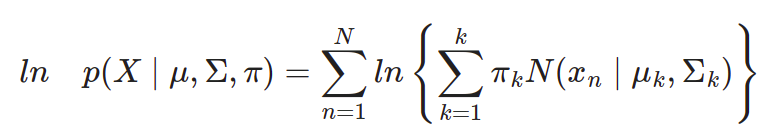

and check for convergence of either the parameters or the log likelihood. If the convergence criterion is not satisfied return to step 2.

In [1]:
#Implementation (w/o log likelihood evaluation)

import numpy as np
from scipy.stats import multivariate_normal

class EM:
    def __init__(self,X,clusters=2,init_cov_size=120):
        self.X = X
        self.clusters = clusters
        datapoints = self.X.shape[0]
        dims = self.X.shape[1]
        self.it = 0
        self.init_cov_size = init_cov_size
        
        # initialize using identity matrices and random points
        # self.cluster_centers = np.random.uniform(low=self.X.min(axis=0),high=self.X.max(axis=0),size=(self.clusters,self.X.shape[1]))
        # init means with random points from the data; seems to result in fewer singulartities
        rand = np.random.choice(datapoints, self.clusters,replace=False)
        self.cluster_centers = self.X[rand,:]
        
        self.cluster_covs = np.stack([np.eye(dims)*self.init_cov_size]*self.clusters,axis=0)
        self.mixing_coeffs = np.full(self.clusters,1/self.clusters)
        
    def fit(self,iterations=10):
        for i in range(iterations):  
            # Expectation_step
            self.responsibilities = self._expectation(self.X)
            # Maximization_step
            self._maximization()
            self.it += 1
        return self.cluster_centers, self.cluster_covs
    
    def _expectation(self,X):
        tripel = zip(self.cluster_centers,self.cluster_covs,self.mixing_coeffs)
        responsibilities = np.zeros((self.clusters,X.shape[0]))
        divisor_sum = np.zeros((X.shape[0]))
        
        for i,(mean,cov,mixing_coeff) in enumerate(tripel):
            resp = mixing_coeff * multivariate_normal.pdf(X,mean,cov,allow_singular=True)
            responsibilities[i] = resp
            divisor_sum += resp
        responsibilities /= divisor_sum
        return responsibilities

    
    def _maximization(self):
        X = self.X
        for i,resp in enumerate(self.responsibilities):
            Nk = resp.sum()
            if Nk <= 1:
                # catch nearby singularities
                print("Singularity detected")
                
                
                # choosing new mean uniformly random
                # new_mean = np.random.uniform(low=self.X.min(axis=0),high=self.X.max(axis=0))
                # choosing random points form X as mean
                
                rand = np.random.choice(datapoints, self.clusters,replace=False)
                new_mean = X[rand,:]
                
                new_cov = np.eye(self.X.shape[1]) * self.init_cov_size
            else:
                new_mean = 1/Nk * (resp[:,np.newaxis]*X).sum(axis=0)
                unweighted_product = np.einsum('ji,jk->jik', (X-new_mean), (X-new_mean))
                cov_sum = (resp[:,np.newaxis,np.newaxis]*unweighted_product).sum(axis=0)
                new_cov = 1/Nk * cov_sum
            new_mixing_coeff = Nk/X.shape[0]
            
            self.cluster_centers[i] = new_mean
            self.cluster_covs[i] = new_cov
            self.mixing_coeffs[i] = new_mixing_coeff
                
    def predict(self,X):
        resp = self._expectation(X)
        cluster_prediction = resp.argmax(axis=0)
        prediction = np.copy(X)
        for i,mean in enumerate(self.cluster_centers):
            prediction[cluster_prediction==i] = mean
        return prediction
           

In [2]:
#Visualizing utils

from numpy import pi, sin, cos
import matplotlib.pyplot as plt
%matplotlib inline

def oval(cov, num_points=100,radius=1):
    arcs = np.linspace(0, 2 * pi, num_points)
    x = radius * sin(arcs)
    y = radius * cos(arcs)
    
    xy = np.array(list(zip(x, y)))
    x, y = zip(*xy.dot(cov))
    return x,y

def make_plot(a):
    plt.figure(figsize=(6, 5))
    plt.title("EM iteration {}".format(a.it))

    colors = ['g', 'r', 'c', 'm', 'y', 'b' ]
    
    # selcect elements based on expectation
    x, y = zip(*X)
    try:
        plt.scatter(x, y, edgecolors="black",c=a.responsibilities[0],cmap='RdYlGn')
    except AttributeError:
        plt.scatter(x, y, edgecolors="black",color='y')
    for i in range(a.cluster_centers.shape[0]):
        # plot centers
        plt.scatter(a.cluster_centers[i,0],a.cluster_centers[i,1],s=250,color=colors[i],edgecolors="white")

        # plot ovals that show the shape of the  variances
        x, y = oval(a.cluster_covs[i],radius=2)
        x += a.cluster_centers[i,0]
        y += a.cluster_centers[i,1]
        plt.plot(x, y,linewidth=5,color=colors[i])

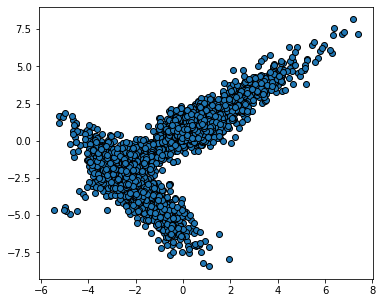

In [3]:
#2d Dataset
import pandas as pd

# import dataset
X = pd.read_csv("data/2d_em.csv", header=None).to_numpy()
# plot dataset
x, y = zip(*X)
plt.figure(figsize=(6, 5))
plt.scatter(x, y, edgecolors="black")

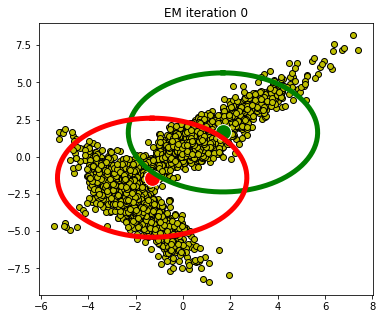

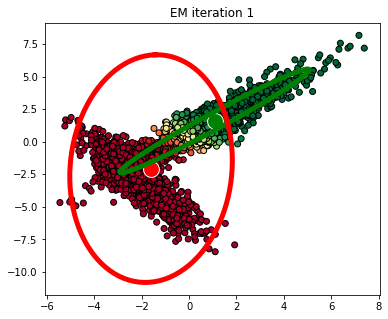

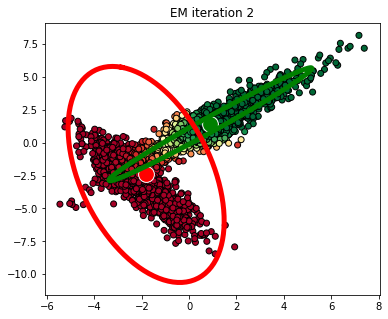

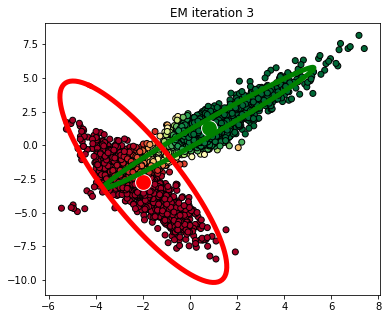

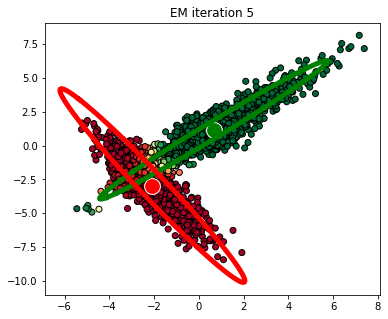

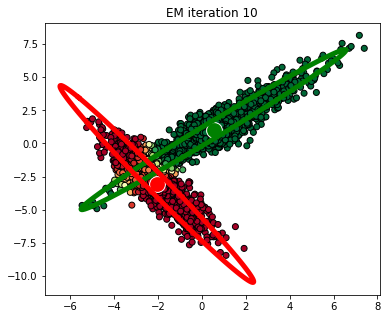

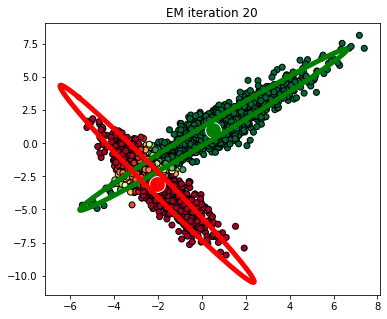

In [4]:
a = EM(X,2,init_cov_size=2)
for i in [1,1,1,2,5,10,10]:
    make_plot(a)
    mm = a.fit(i)